<a href="https://colab.research.google.com/github/JYSIRI/ADS1-_-ASSIGNMENT-2/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycocotools -q

import os
import json
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import functional as TF

from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Torch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


In [2]:
from google.colab import files
import zipfile, os, glob

# 1) Uploading the ZIP file
uploaded = files.upload()  # choose RMDS_Segmentation_Assignment.zip

zip_name = list(uploaded.keys())[0]
print("Uploaded ZIP:", zip_name)

# 2) Extracting to the clean root
EXTRACT_ROOT = "/content/rmds_data"
os.makedirs(EXTRACT_ROOT, exist_ok=True)

with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(EXTRACT_ROOT)

print("Extracted to:", EXTRACT_ROOT)

# 3) Auto-finding  training-300/labels.json
candidates = glob.glob(os.path.join(EXTRACT_ROOT, "**", "train-300", "labels.json"), recursive=True)

print("\nFound candidates for train-300/labels.json:")
for c in candidates:
    print("  ", c)

if not candidates:
    raise FileNotFoundError(
        "Could not find any 'train-300/labels.json' under "
        f"{EXTRACT_ROOT}. Check the ZIP contents."
    )

# 4) Using  the first candidate as  true path
train_ann_path = candidates[0]
TRAIN_DIR = os.path.dirname(train_ann_path)
BASE_DIR  = os.path.dirname(TRAIN_DIR)

VAL_DIR   = os.path.join(BASE_DIR, "validation-300")
TEST_DIR  = os.path.join(BASE_DIR, "test-30")
TRAIN_IMG_DIR = os.path.join(TRAIN_DIR, "data")
VAL_IMG_DIR   = os.path.join(VAL_DIR, "data")
val_ann_path  = os.path.join(VAL_DIR, "labels.json")

print("\nResolved paths:")
print("BASE_DIR     :", BASE_DIR)
print("TRAIN_DIR    :", TRAIN_DIR)
print("VAL_DIR      :", VAL_DIR)
print("TEST_DIR     :", TEST_DIR)
print("train_ann_path:", train_ann_path)
print("val_ann_path  :", val_ann_path)

print("\nExist checks:")
print("Train ann exists:", os.path.exists(train_ann_path))
print("Val ann exists  :", os.path.exists(val_ann_path))
print("Train img dir   :", os.path.exists(TRAIN_IMG_DIR))
print("Val img dir     :", os.path.exists(VAL_IMG_DIR))
print("Test dir        :", os.path.exists(TEST_DIR))

Saving RMDS_Segmentation_Assignment.zip to RMDS_Segmentation_Assignment.zip
Uploaded ZIP: RMDS_Segmentation_Assignment.zip
Extracted to: /content/rmds_data

Found candidates for train-300/labels.json:
   /content/rmds_data/train-300/labels.json

Resolved paths:
BASE_DIR     : /content/rmds_data
TRAIN_DIR    : /content/rmds_data/train-300
VAL_DIR      : /content/rmds_data/validation-300
TEST_DIR     : /content/rmds_data/test-30
train_ann_path: /content/rmds_data/train-300/labels.json
val_ann_path  : /content/rmds_data/validation-300/labels.json

Exist checks:
Train ann exists: True
Val ann exists  : True
Train img dir   : True
Val img dir     : True
Test dir        : True


In [3]:
# Loading the COCO annotations
coco_train = COCO(train_ann_path)
coco_val   = COCO(val_ann_path)

def build_cat_maps(coco_obj):
    cats = coco_obj.loadCats(coco_obj.getCatIds())
    id2name = {c['id']: c['name'] for c in cats}
    name2id = {c['name'].lower(): c['id'] for c in cats}
    return id2name, name2id

id2name, name2id = build_cat_maps(coco_train)

TARGET_CLASSES = ["person", "cat", "sports ball", "book"]

present_targets = [t for t in TARGET_CLASSES if t.lower() in name2id]
print("Present:", present_targets)

target_orig_ids = [name2id[t.lower()] for t in present_targets]

# mapping  COCO IDs → 1..N (0 = background)
origid_to_new = {orig: idx+1 for idx, orig in enumerate(target_orig_ids)}
new_to_origid = {v: k for k, v in origid_to_new.items()}

NUM_CLASSES = len(origid_to_new) + 1
print("NUM_CLASSES:", NUM_CLASSES)
print("origid_to_new:", origid_to_new)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Present: ['person', 'cat', 'sports ball', 'book']
NUM_CLASSES: 5
origid_to_new: {1: 1, 17: 2, 37: 3, 84: 4}


In [4]:
from pathlib import Path

def precompute_for_split(img_dir, ann_path, split_name):
    coco = COCO(ann_path)

    img_ids = set()
    for cid in target_orig_ids:
        img_ids.update(coco.getImgIds(catIds=[cid]))
    img_ids = sorted(img_ids)

    out_dir = os.path.join(BASE_DIR, f"precomputed_{split_name}")
    os.makedirs(out_dir, exist_ok=True)

    # Removing the old npz files
    for f in Path(out_dir).glob("*.npz"):
        f.unlink()

    print(f"\nPrecomputing {split_name}: {out_dir}")
    print("Images:", len(img_ids))

    saved = 0
    drop_boxes = 0
    drop_images = 0

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info["file_name"]
        H, W = img_info["height"], img_info["width"]

        ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=target_orig_ids)
        anns = coco.loadAnns(ann_ids)

        masks = []
        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for a in anns:
            if a["category_id"] not in origid_to_new:
                continue

            seg = a["segmentation"]
            if isinstance(seg, (dict, list)):
                rles = maskUtils.frPyObjects(seg, H, W)
                if isinstance(rles, list):
                    rle = maskUtils.merge(rles)
                else:
                    rle = rles
            else:
                rle = seg

            m = maskUtils.decode(rle)
            if m.ndim == 3:
                m = np.any(m, axis=2)

            if m.sum() == 0:
                continue

            ys, xs = np.where(m)
            xmin, ymin = float(xs.min()), float(ys.min())
            xmax, ymax = float(xs.max()), float(ys.max())
            w = xmax - xmin
            h = ymax - ymin

            if w <= 0 or h <= 0:
                drop_boxes += 1
                continue

            masks.append(m.astype(np.uint8))
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(origid_to_new[a["category_id"]])
            areas.append(w * h)
            iscrowd.append(int(a.get("iscrowd", 0)))

        if len(masks) == 0:
            drop_images += 1
            continue

        np.savez(
            os.path.join(out_dir, file_name + ".npz"),
            image_id=img_id,
            file_name=file_name,
            masks=np.stack(masks),
            boxes=np.array(boxes, dtype=np.float32),
            labels=np.array(labels, dtype=np.int64),
            areas=np.array(areas, dtype=np.float32),
            iscrowd=np.array(iscrowd, dtype=np.int64)
        )
        saved += 1

    print("Saved:", saved)
    print("Dropped boxes:", drop_boxes)
    print("Dropped images:", drop_images)

precompute_for_split(TRAIN_IMG_DIR, train_ann_path, "train")
precompute_for_split(VAL_IMG_DIR,   val_ann_path,   "val")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!

Precomputing train: /content/rmds_data/precomputed_train
Images: 300
Saved: 300
Dropped boxes: 1
Dropped images: 0
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!

Precomputing val: /content/rmds_data/precomputed_val
Images: 300
Saved: 300
Dropped boxes: 0
Dropped images: 0


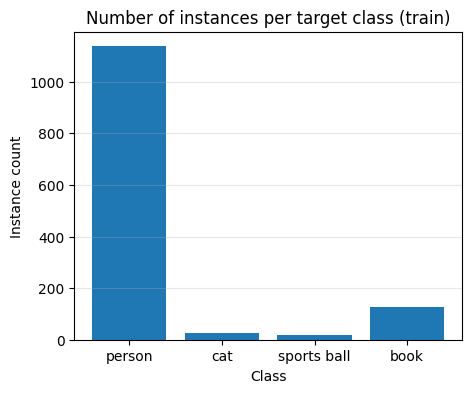

In [5]:
import collections
import matplotlib.pyplot as plt

# Using EDA Cell A – count instances per class using precomputed train .npz

pre_train_dir = os.path.join(BASE_DIR, "precomputed_train")

def count_instances_per_class(pre_dir):
    counter = collections.Counter()
    for f in Path(pre_dir).glob("*.npz"):
        data = np.load(f)
        labels = data["labels"]  # array of new-label ints (1..N)
        for lab in labels:
            counter[int(lab)] += 1
    return counter

instance_counts = count_instances_per_class(pre_train_dir)

# Mapping new labels (1..N) back to names
new_label_names = {}
for new_lab, orig_lab in new_to_origid.items():
    name = id2name[orig_lab]  # id2name from earlier COCO mapping
    new_label_names[new_lab] = name

# Preparing  for plotting
labels_sorted = sorted(instance_counts.keys())
names = [new_label_names[l] for l in labels_sorted]
counts = [instance_counts[l] for l in labels_sorted]

plt.figure(figsize=(5,4))
plt.bar(names, counts)
plt.title("Number of instances per target class (train)")
plt.xlabel("Class")
plt.ylabel("Instance count")
plt.grid(axis="y", alpha=0.3)
plt.show()


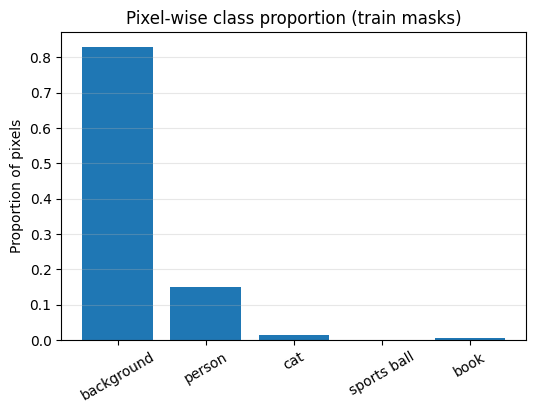

Pixel counts: [67894731 12332294  1237184     3037   324954]
Proportions:  [8.30088089e-01 1.50775918e-01 1.51259411e-02 3.71306799e-05
 3.97292162e-03]


In [6]:
# Using EDA Cell B – pixel-wise distribution of classes in train masks

def compute_pixel_distribution(pre_dir, num_classes):
    pixel_counts = np.zeros(num_classes, dtype=np.int64)  # 0 = background, 1..N

    for f in Path(pre_dir).glob("*.npz"):
        data = np.load(f)
        masks = data["masks"]        # [N,H,W]
        labels = data["labels"]      # [N]

        # Build a combined semantic map with label IDs
        if masks.size == 0:
            continue
        H, W = masks.shape[1], masks.shape[2]
        combined = np.zeros((H, W), dtype=np.int32)  # background = 0

        for inst_mask, lab in zip(masks, labels):
            combined[inst_mask.astype(bool)] = int(lab)

        # Count pixels per class
        for c in range(num_classes):
            pixel_counts[c] += (combined == c).sum()

    return pixel_counts

pixel_counts = compute_pixel_distribution(pre_train_dir, NUM_CLASSES)

class_names = ["background"] + [new_label_names[l] for l in sorted(new_to_origid.keys())]
proportions = pixel_counts / pixel_counts.sum()

plt.figure(figsize=(6,4))
plt.bar(class_names, proportions)
plt.title("Pixel-wise class proportion (train masks)")
plt.ylabel("Proportion of pixels")
plt.xticks(rotation=30)
plt.grid(axis="y", alpha=0.3)
plt.show()

print("Pixel counts:", pixel_counts)
print("Proportions: ", proportions)

In [7]:
import os

def show_gt_masks(pre_dir, img_dir, indices=[0, 5, 10]):
    npz_files = sorted(Path(pre_dir).glob("*.npz"))
    print(f"Total precomputed train files: {len(npz_files)}")

    # 🔹 Making  a dedicated folder for EDA gt-mask outputs
    out_dir = "eda_gt_masks"
    os.makedirs(out_dir, exist_ok=True)

    for idx in indices:
        if idx < 0 or idx >= len(npz_files):
            print(f"Index {idx} out of range, skipping.")
            continue

        data = np.load(npz_files[idx])
        file_name = str(data["file_name"])
        img_path = os.path.join(img_dir, file_name)

        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        masks = data["masks"]   # [N,H,W]
        labels = data["labels"] # [N]

        combined_mask = np.zeros(img_np.shape[:2], dtype=bool)
        for m in masks:
            combined_mask |= m.astype(bool)

        color_mask = np.zeros_like(img_np)
        color_mask[..., 1] = 255  # green overlay

        alpha = 0.5
        overlay = img_np.copy()
        overlay[combined_mask] = (
            alpha * color_mask[combined_mask] +
            (1 - alpha) * overlay[combined_mask]
        ).astype(np.uint8)

        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        ax[0].imshow(img_np)
        ax[0].set_title(f"Train image (idx {idx})")
        ax[0].axis("off")

        ax[1].imshow(overlay)
        ax[1].set_title("Ground-truth masks overlay")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()

        #  Saving in eda_gt_masks/
        save_path = os.path.join(out_dir, f"gtmask_idx_{idx}.png")
        fig.savefig(save_path, dpi=120, bbox_inches="tight")
        print("Saved:", save_path)

        plt.close(fig)

Total precomputed train files: 300


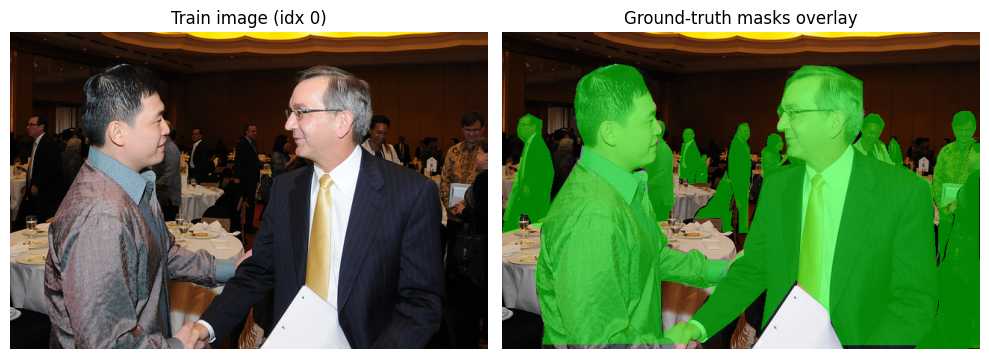

Saved: eda_gt_masks/gtmask_idx_0.png


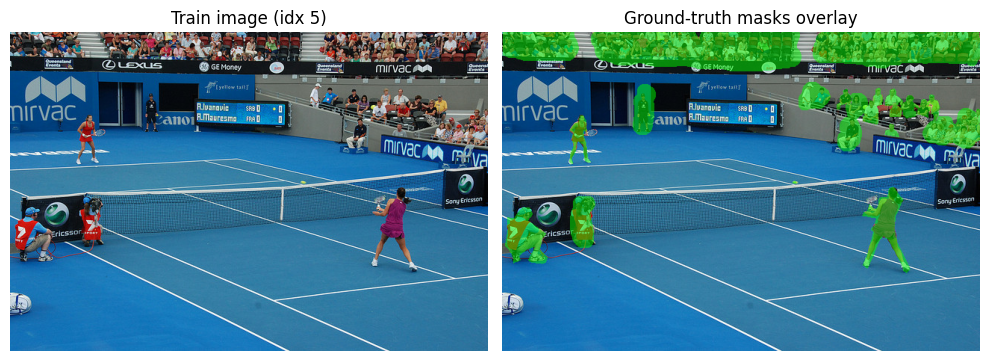

Saved: eda_gt_masks/gtmask_idx_5.png


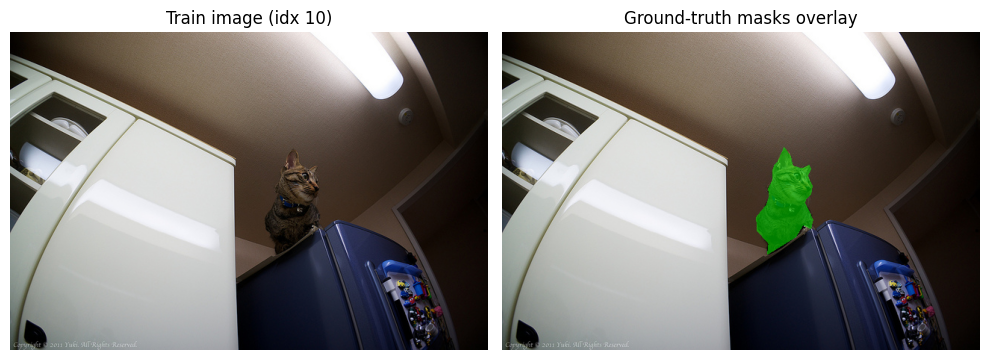

Saved: eda_gt_masks/gtmask_idx_10.png


In [8]:
pre_train_dir = os.path.join(BASE_DIR, "precomputed_train")

show_gt_masks(
    pre_dir=pre_train_dir,
    img_dir=TRAIN_IMG_DIR,
    indices=[0, 5, 10]
)

In [9]:
import torchvision.transforms.functional as TF

class ComposeDouble:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensorTransform:
    def __call__(self, image, target):
        return TF.to_tensor(image), target

class RandomHorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob
    def __call__(self, image, target):
        if np.random.rand() < self.prob:
            image = image.flip(-1)
            _, H, W = image.shape

            boxes = target["boxes"]
            x_min = boxes[:, 0].clone()
            x_max = boxes[:, 2].clone()
            boxes[:, 0] = W - x_max
            boxes[:, 2] = W - x_min
            target["boxes"] = boxes

            target["masks"] = target["masks"].flip(-1)

        return image, target

train_transforms = ComposeDouble([ToTensorTransform(), RandomHorizontalFlip(0.5)])
val_transforms   = ComposeDouble([ToTensorTransform()])

In [10]:
class PrecomputedMaskRCNNDataset(Dataset):
    def __init__(self, img_dir, pre_dir, transforms=None):
        self.img_dir = img_dir
        self.pre_dir = pre_dir
        self.transforms = transforms
        self.files = sorted(Path(pre_dir).glob("*.npz"))
        print(f"Loaded {len(self.files)} annotation files from {pre_dir}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])

        #  IMPORTANT to FIX: converting np.ndarray → Python string
        file_name = str(data["file_name"])

        img_path = os.path.join(self.img_dir, file_name)
        img = Image.open(img_path).convert("RGB")

        target = {
            "boxes":   torch.as_tensor(data["boxes"], dtype=torch.float32),
            "labels":  torch.as_tensor(data["labels"], dtype=torch.int64),
            "masks":   torch.as_tensor(data["masks"], dtype=torch.uint8),
            "image_id": torch.tensor([int(data["image_id"])]),
            "area":    torch.as_tensor(data["areas"], dtype=torch.float32),
            "iscrowd": torch.as_tensor(data["iscrowd"], dtype=torch.int64),
        }

        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target

In [11]:
pre_train_dir = f"{BASE_DIR}/precomputed_train"
pre_val_dir   = f"{BASE_DIR}/precomputed_val"

train_dataset = PrecomputedMaskRCNNDataset(
    TRAIN_IMG_DIR,
    pre_train_dir,
    transforms=train_transforms
)
val_dataset   = PrecomputedMaskRCNNDataset(
    VAL_IMG_DIR,
    pre_val_dir,
    transforms=val_transforms
)

#
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader   = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

print("Train dataset size:", len(train_dataset))
print("Val dataset size:  ", len(val_dataset))

Loaded 300 annotation files from /content/rmds_data/precomputed_train
Loaded 300 annotation files from /content/rmds_data/precomputed_val
Train dataset size: 300
Val dataset size:   300


In [12]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_custom_maskrcnn(num_classes):
    model = maskrcnn_resnet50_fpn(weights="COCO_V1")

    # Box head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Mask head
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        256,
        num_classes
    )

    # Custom tweaks
    model.transform.min_size = (400,)
    model.transform.max_size = 800
    model.rpn.anchor_generator.sizes = ((16, 32, 64, 128, 256),)

    return model

model = get_custom_maskrcnn(NUM_CLASSES)
model.to(device)
print("Model ready.")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:01<00:00, 137MB/s]


Model ready.


In [13]:
import time

def train_one_epoch(model, loader, optimizer, device, epoch):
    model.train()
    total = 0
    for step, (images, targets) in enumerate(loader):
        images = [i.to(device) for i in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total += losses.item()

        if (step+1) % 20 == 0:
            print(f"Epoch {epoch} | Step {step+1}/{len(loader)} | Loss: {losses.item():.4f}")

    return total / len(loader)

@torch.no_grad()
def evaluate_on_val(model, loader, device):
    model.train()  # important so loss_dict is returned
    total = 0
    for images, targets in loader:
        images = [i.to(device) for i in images]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())
        total += losses.item()
    return total / len(loader)

In [14]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 5
best_val = float('inf')
save_path = f"{BASE_DIR}/maskrcnn_4classes_precomputed.pth"

for epoch in range(1, num_epochs+1):
    start = time.time()

    train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
    val_loss   = evaluate_on_val(model, val_loader, device)
    lr_scheduler.step()

    print(f"\nEpoch {epoch} done in { (time.time()-start)/60:.1f} min")
    print("Train Loss:", train_loss)
    print("Val Loss:  ", val_loss)

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), save_path)
        print(f" Best model saved to {save_path}")

print("\nTraining finished. Best val loss =", best_val)

Epoch 1 | Step 20/150 | Loss: 0.6991
Epoch 1 | Step 40/150 | Loss: 1.1453
Epoch 1 | Step 60/150 | Loss: 1.0405
Epoch 1 | Step 80/150 | Loss: 0.8148
Epoch 1 | Step 100/150 | Loss: 0.9609
Epoch 1 | Step 120/150 | Loss: 0.4091
Epoch 1 | Step 140/150 | Loss: 0.9953

Epoch 1 done in 0.9 min
Train Loss: 1.1265001990397772
Val Loss:   0.9034030977884928
 Best model saved to /content/rmds_data/maskrcnn_4classes_precomputed.pth
Epoch 2 | Step 20/150 | Loss: 0.4748
Epoch 2 | Step 40/150 | Loss: 1.2516
Epoch 2 | Step 60/150 | Loss: 1.5814
Epoch 2 | Step 80/150 | Loss: 1.1216
Epoch 2 | Step 100/150 | Loss: 0.6496
Epoch 2 | Step 120/150 | Loss: 1.5806
Epoch 2 | Step 140/150 | Loss: 1.4094

Epoch 2 done in 1.0 min
Train Loss: 0.8469183808565139
Val Loss:   0.8322914264599482
 Best model saved to /content/rmds_data/maskrcnn_4classes_precomputed.pth
Epoch 3 | Step 20/150 | Loss: 0.9255
Epoch 3 | Step 40/150 | Loss: 1.6087
Epoch 3 | Step 60/150 | Loss: 0.1526
Epoch 3 | Step 80/150 | Loss: 0.1743
Epoch 

In [15]:
best_model_path = f"{BASE_DIR}/maskrcnn_4classes_precomputed.pth"

model = get_custom_maskrcnn(NUM_CLASSES)
state_dict = torch.load(best_model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("Loaded best model from:", best_model_path)

Loaded best model from: /content/rmds_data/maskrcnn_4classes_precomputed.pth


In [16]:
import glob

import os

@torch.no_grad()
def show_test_predictions(model, img_paths, score_thresh=0.7):
    model.eval()
    os.makedirs("test_prediction_outputs", exist_ok=True)

    for img_path in img_paths:
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)
        img_tensor = TF.to_tensor(img).to(device)

        outputs = model([img_tensor])[0]

        scores = outputs["scores"].cpu().numpy()
        keep = scores >= score_thresh

        boxes  = outputs["boxes"][keep].cpu().numpy()
        masks  = outputs["masks"][keep].cpu().numpy()
        labels = outputs["labels"][keep].cpu().numpy()

        print(f"\nImage: {os.path.basename(img_path)} | kept={keep.sum()}")

        combined_mask = np.zeros(img_np.shape[:2], dtype=np.float32)
        for m in masks:
            combined_mask = np.maximum(combined_mask, m[0])

        color_mask = np.zeros_like(img_np)
        color_mask[..., 0] = 255  # red overlay

        alpha = 0.5
        overlay = (
            img_np * (1 - alpha * combined_mask[..., None]) +
            color_mask * (alpha * combined_mask[..., None])
        ).astype(np.uint8)

        # ---- PLOT ----
        fig = plt.figure(figsize=(10,4))

        plt.subplot(1,2,1)
        plt.imshow(img_np)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(overlay)
        plt.title("Predicted Masks")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        # ---- SAVE ----
        base = os.path.splitext(os.path.basename(img_path))[0]
        save_path = f"test_prediction_outputs/test_pred_{base}.png"
        fig.savefig(save_path, dpi=120, bbox_inches="tight")
        print("Saved:", save_path)

        plt.close(fig)

Test images found: 30

Image: 000000013177.jpg | kept=1


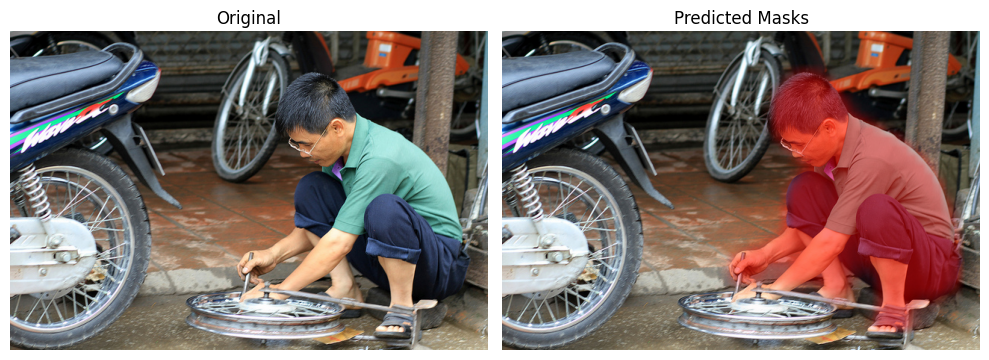

Saved: test_prediction_outputs/test_pred_000000013177.png

Image: 000000117525.jpg | kept=1


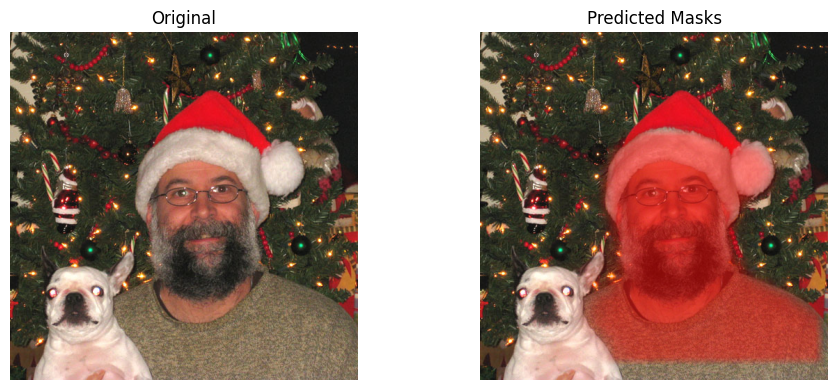

Saved: test_prediction_outputs/test_pred_000000117525.png

Image: 000000161032.jpg | kept=1


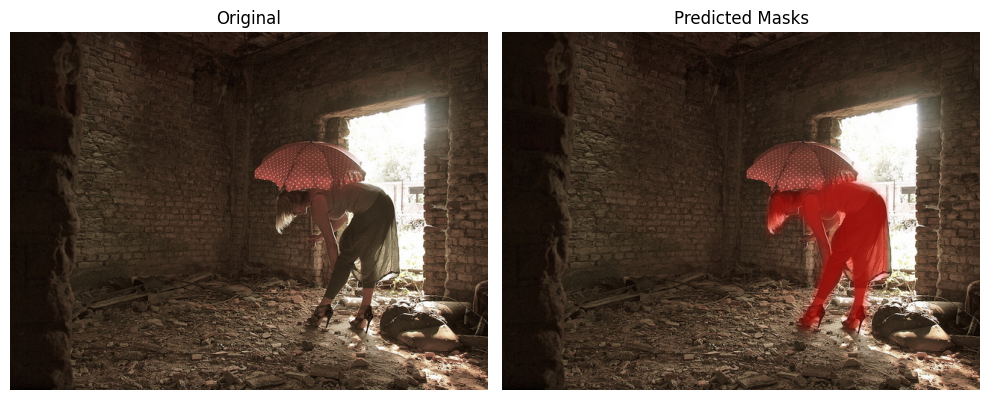

Saved: test_prediction_outputs/test_pred_000000161032.png


In [17]:
import glob, os

# Rebuilding the test image list
test_img_paths = sorted(glob.glob(os.path.join(TEST_DIR, "*.jpg")))
print("Test images found:", len(test_img_paths))

# To Pick indices 0, 5, 10 like before
test_indices = [0, 5, 10]
test_subset = [test_img_paths[i] for i in test_indices if i < len(test_img_paths)]

#  To CALL the function
show_test_predictions(model, test_subset, score_thresh=0.7)

In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

@torch.no_grad()
def show_predictions(model, dataset, idx_list, score_thresh=0.5):
    model.eval()
    print("Dataset length:", len(dataset))
    print("Requested indices:", idx_list)

    # creating a folder for saving predictions
    out_dir = "pred_val_images"
    os.makedirs(out_dir, exist_ok=True)

    for idx in idx_list:
        if idx < 0 or idx >= len(dataset):
            print(f"⚠️ Skipping idx {idx} (out of range)")
            continue

        print(f"\nProcessing idx {idx}...")
        img, target = dataset[idx]

        img_device = img.to(device)
        outputs = model([img_device])[0]

        scores = outputs["scores"].cpu().numpy()
        keep = scores >= score_thresh

        print(f"  Predictions: {len(scores)} total, {keep.sum()} kept (≥ {score_thresh})")

        masks  = outputs["masks"][keep].cpu().numpy()
        boxes  = outputs["boxes"][keep].cpu().numpy()
        labels = outputs["labels"][keep].cpu().numpy()

        img_np = img.permute(1, 2, 0).cpu().numpy()

        # ----- Plot -----
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        # Original image
        ax[0].imshow(img_np)
        ax[0].set_title(f"Original (idx {idx})")
        ax[0].axis("off")

        # Overlay prediction mask
        overlay = img_np.copy()
        if len(masks) > 0:
            combined = np.zeros(img_np.shape[:2], dtype=np.float32)
            for m in masks:
                combined = np.maximum(combined, m[0])

            color_mask = np.zeros_like(img_np)
            color_mask[..., 0] = 1.0   # red channel

            alpha = 0.5
            overlay = (
                img_np * (1 - alpha * combined[..., None]) +
                color_mask * (alpha * combined[..., None])
            )

        ax[1].imshow(overlay)
        ax[1].set_title(f"Predicted Masks (idx {idx})")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()

        # Save output
        save_path = os.path.join(out_dir, f"pred_val_idx_{idx}.png")
        fig.savefig(save_path, dpi=120, bbox_inches="tight")
        print("Saved:", save_path)

        plt.close(fig)

Dataset length: 300
Requested indices: [0, 1, 2]

Processing idx 0...
  Predictions: 43 total, 9 kept (≥ 0.7)


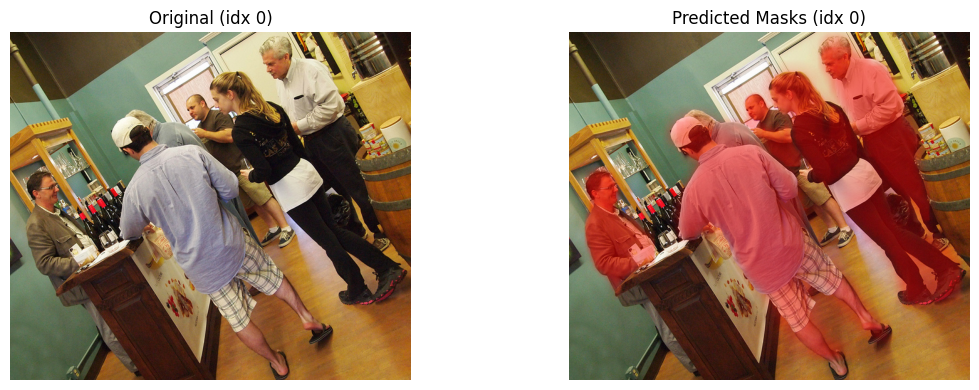

Saved: pred_val_images/pred_val_idx_0.png

Processing idx 1...
  Predictions: 6 total, 1 kept (≥ 0.7)


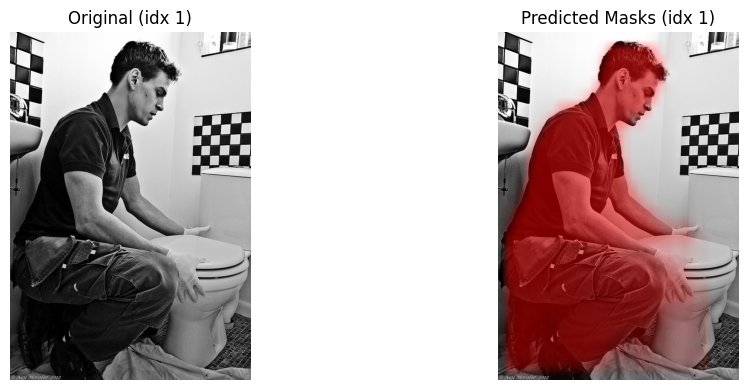

Saved: pred_val_images/pred_val_idx_1.png

Processing idx 2...
  Predictions: 38 total, 10 kept (≥ 0.7)


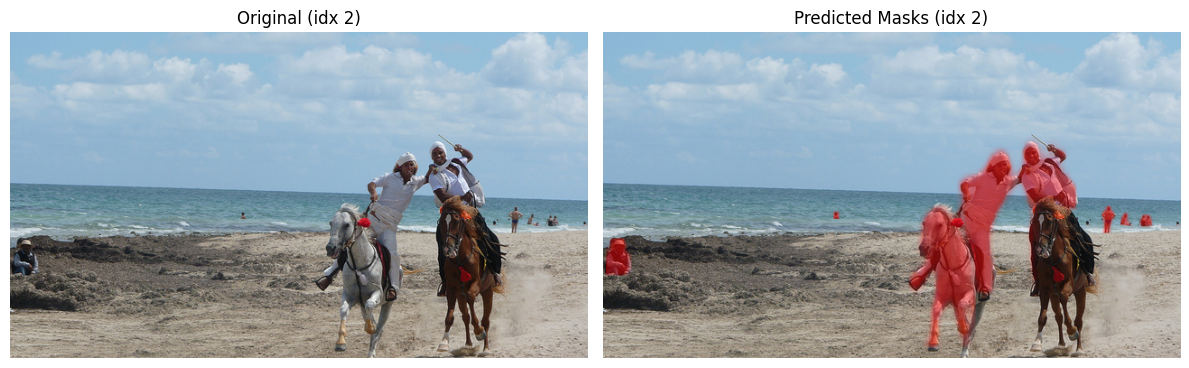

Saved: pred_val_images/pred_val_idx_2.png


In [19]:
# Useing small indices that definitely exist
show_predictions(model, val_dataset, idx_list=[0, 1, 2], score_thresh=0.7)